<a href="https://colab.research.google.com/github/michelleli1999/SMILES2vec-with-Attention/blob/main/FINAL590_ML_ET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

In this notebook, we created our own custom SMILES2vec with attention model, called custom attention model. Then, we recreated the SMILES2vec and message-passing neural network (MPNN) using Keras API interface so that we can compare our custom model to SMILES2vec and MPNN. We looked at the performance of SMILES2vec and MPNN trained on a classifcation dataset, ClinTox, and regression dataset, FreeSolv. Finally, we performed adversarial control to further evaluate our own model's performance. 

In [ ]:
!pip install --pre deepchem
!pip install rdkit-pypi
!pip install tensorflow-addons

     |████████████████████████████████| 608 kB 7.1 MB/s 
     |████████████████████████████████| 20.6 MB 90 kB/s 
     |████████████████████████████████| 1.1 MB 9.6 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import itertools
import deepchem as dc
import numpy as np
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

# Performance of SMILES2vec, MPNN, and Custom Attention on ClinTox Classification

## Data preprocessing

In [ ]:
tasks, dataset, transformers = dc.molnet.load_clintox()
train_dataset, valid_dataset, test_dataset = dataset

In [ ]:
smiles_list = [x for x in itertools.chain(train_dataset.ids, valid_dataset.ids, test_dataset.ids)]

In [ ]:
charset = set("".join(list(smiles_list))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in smiles_list]) + 5

In [ ]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

## SMILES2vec Trained on ClinTox

In [ ]:
#Prepare features for SMILES2vec
X_train, _ = vectorize(train_dataset.ids)
X_valid, _ = vectorize(valid_dataset.ids)
X_test, _ = vectorize(test_dataset.ids)

In [ ]:
#Second task in ClinTox which is FDA approval 
Y_train = train_dataset.y[:,1]
Y_valid = valid_dataset.y[:,1]
Y_test = test_dataset.y[:,1]

mol_str_train=[]
mol_str_valid=[]
mol_str_test=[]

for x in range(len(train_dataset.ids)):
    mol_str_train.append("".join([int_to_char[idx] for idx in np.argmax(X_train[x,:,:], axis=1)]))

for x in range(len(valid_dataset.ids)):
    mol_str_valid.append("".join([int_to_char[idx] for idx in np.argmax(X_valid[x,:,:], axis=1)]))

for x in range(len(test_dataset.ids)):
    mol_str_test.append("".join([int_to_char[idx] for idx in np.argmax(X_test[x,:,:], axis=1)]))

vocab_size=len(charset)

In [ ]:
#Initialize SMILES2vec model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 50, input_length=embed-1))
model.add(tf.keras.layers.Conv1D(192,10,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())                            
model.add(keras.layers.LSTM(224,return_sequences=True))
model.add(keras.layers.LSTM(384,return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [ ]:
mol_str_train = np.asarray(mol_str_train)
mol_str_valid = np.asarray(mol_str_valid)
mol_str_test = np.asarray(mol_str_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


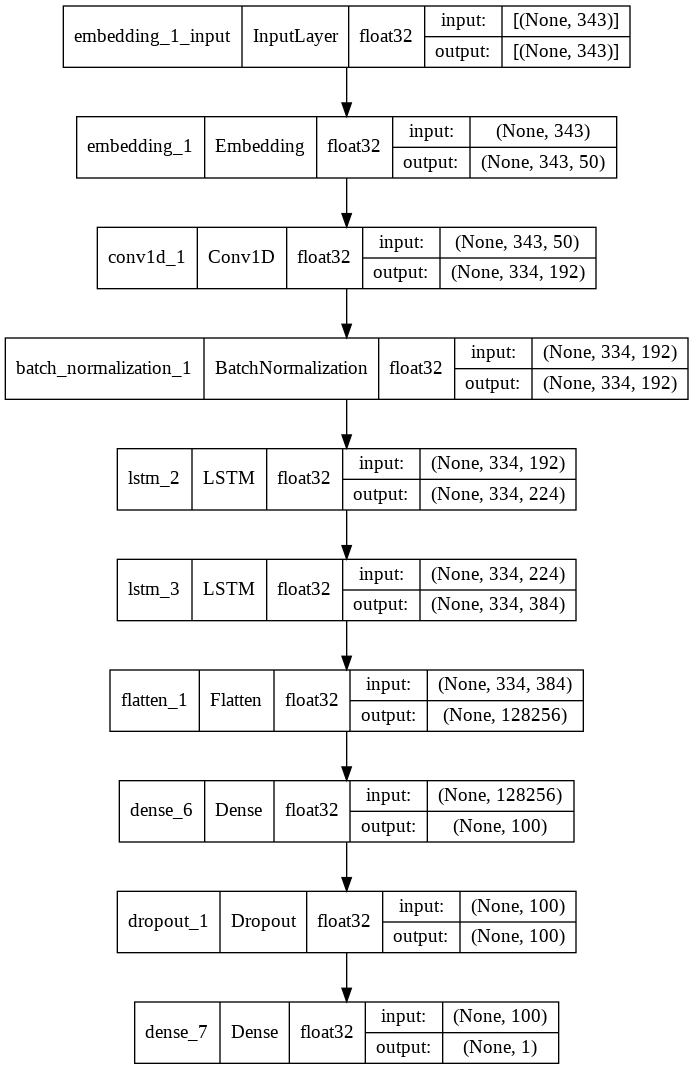

In [ ]:
optimizer = Adam(lr=0.003)
lr_metric = get_lr_metric(optimizer)
model.compile(loss= tfa.losses.SigmoidFocalCrossEntropy(), optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True), lr_metric])
keras.utils.plot_model(model, show_dtype=True, show_shapes=True)

In [ ]:
#Train model
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00005, verbose=1, mode='auto',cooldown=0),
    #ModelCheckpoint(filepath="/content/drive/MyDrive/FINAL590_model_weights/SMILES2vec1", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')
    
]



history =model.fit(x=np.argmax(X_train, axis=2), y=Y_train,
                              batch_size=32,
                              epochs=20,
                              class_weight={1: 2.0, 0: 0.5},
                              validation_data=(np.argmax(X_valid, axis=2),Y_valid),
                              callbacks=callbacks_list)


Epoch 1/20
37/37 [==============================] - 7s 105ms/step - loss: 1857.6782 - accuracy: 0.7927 - auc_1: 0.5813 - lr: 0.0030 - val_loss: 1.7412 - val_accuracy: 0.9527 - val_auc_1: 0.8100 - val_lr: 0.0030
Epoch 2/20
37/37 [==============================] - 3s 71ms/step - loss: 0.9689 - accuracy: 0.8985 - auc_1: 0.8267 - lr: 0.0030 - val_loss: 0.3708 - val_accuracy: 0.9527 - val_auc_1: 0.9083 - val_lr: 0.0030
Epoch 3/20
37/37 [==============================] - 3s 71ms/step - loss: 0.6668 - accuracy: 0.9078 - auc_1: 0.7867 - lr: 0.0030 - val_loss: 0.2348 - val_accuracy: 0.9527 - val_auc_1: 0.9205 - val_lr: 0.0030
Epoch 4/20
37/37 [==============================] - 3s 71ms/step - loss: 0.6002 - accuracy: 0.9196 - auc_1: 0.7992 - lr: 0.0030 - val_loss: 0.2167 - val_accuracy: 0.9527 - val_auc_1: 0.9113 - val_lr: 0.0030
Epoch 5/20
37/37 [==============================] - 3s 71ms/step - loss: 0.5143 - accuracy: 0.9120 - auc_1: 0.7878 - lr: 0.0030 - val_loss: 0.1841 - val_accuracy: 0.952

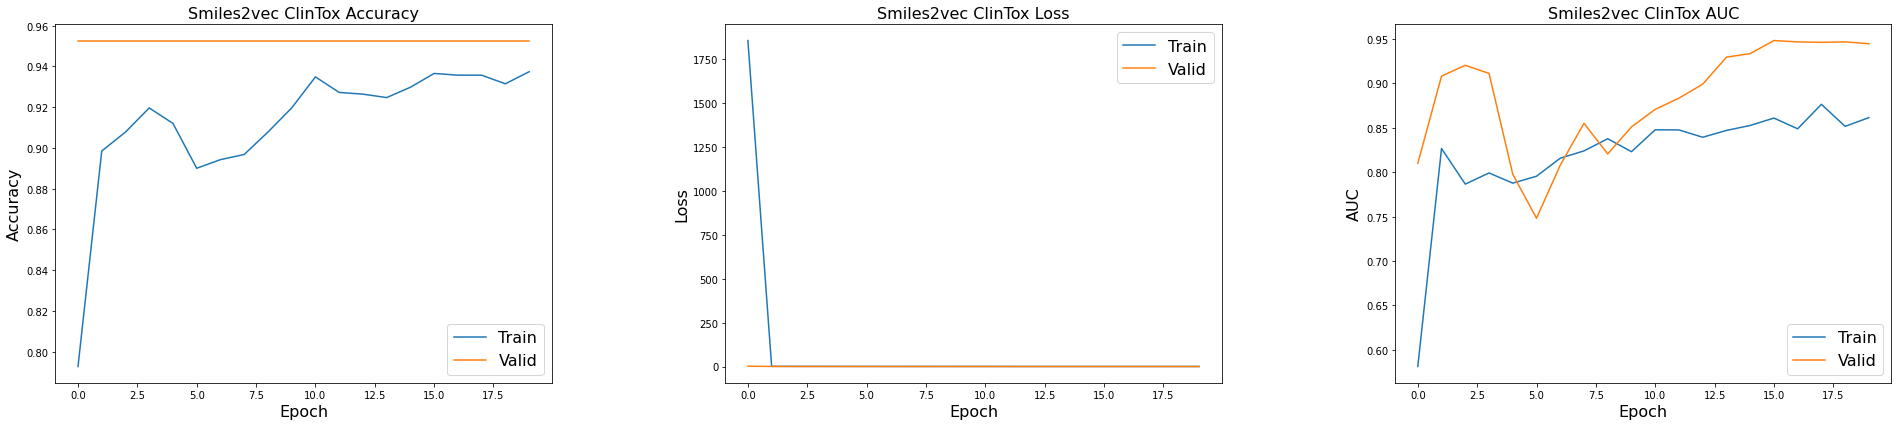

In [ ]:
#Summarize history for Smiles2vec ClinTox Accuracy, Loss, and AUC
plt.figure(figsize=(30, 6))
plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Smiles2vec ClinTox Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='lower right', fontsize=16)

plt.subplot(132)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Smiles2vec ClinTox Loss', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='upper right', fontsize=16)

plt.subplot(133)
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Smiles2vec ClinTox AUC', fontsize=16)
plt.ylabel('AUC', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='lower right', fontsize=16)
    
plt.subplots_adjust(top=0.92, bottom=0.09, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)

In [ ]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

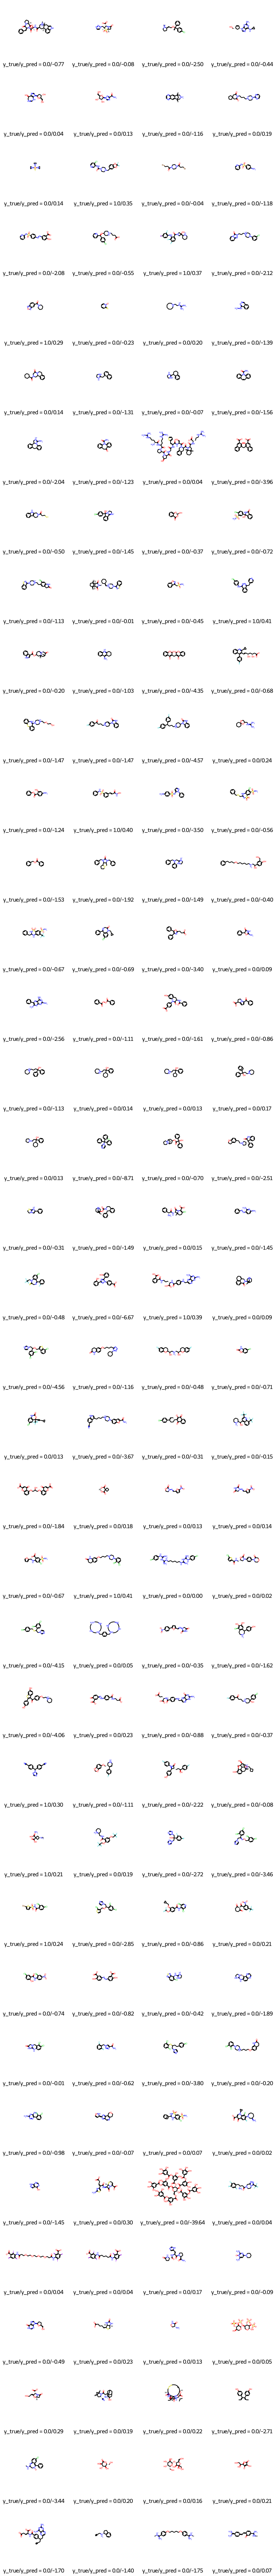

In [ ]:
#Predicting ClinTox task 2 test dataset using SMILES2vec
molecules = [molecule_from_smiles(smi) for smi in test_dataset.ids]
y_pred = (model.predict(x=np.argmax(X_test, axis=2)))
y_pred = y_pred.tolist()
legends = [f"y_true/y_pred = {Y_test[i]}/{y_pred[i][0]:.2f}" for i in range(len(Y_test))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
test_loss, test_acc, test_auc, *is_anything_else_being_returned = model.evaluate(np.argmax(X_test, axis=2), Y_test)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)
print('\nTest AUROC:', test_auc)

5/5 [==============================] - 0s 26ms/step - loss: 0.0102 - accuracy: 0.9324 - auc_1: 0.9935 - lr: 0.0030

Test loss: 0.010167690925300121

Test accuracy: 0.9324324131011963

Test AUROC: 0.9934781789779663


In [ ]:
#Create predictions dataframe for mcnemar test
df = pd.DataFrame()
df['X']=test_dataset.ids
df['base_preds'] = [y_pred[i][0] for i in range(len(Y_test))]
threshold = 0.2
df['threshold_preds'] = df['base_preds']>threshold

## MPNN Trained on ClinTox

In [ ]:
training_dataset, validation_dataset, testing_dataset = dataset

In [ ]:
# Featurizers for MPNN data
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [ ]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loop. Notice, this also helps against some edge cases where the
        # last node has no edges. Alternatively, if no self-loops are used, for these
        # edge cases, zero-padding on the output of the edge network is needed.
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        atom_neighbors = atom.GetNeighbors()

        for neighbor in atom_neighbors:
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

In [ ]:
## MPNN on ClinTox task 2
# Train set
x_train = graphs_from_smiles(training_dataset.ids)
y_train = [x[1] for x in training_dataset.y]

# Valid set
x_valid = graphs_from_smiles(validation_dataset.ids)
y_valid = [x[1] for x in validation_dataset.y]

# Test set
x_test = graphs_from_smiles(testing_dataset.ids)
y_test = [x[1] for x in testing_dataset.y]

In [ ]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices. atom_partition_indices will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    atom_partition_indices = tf.repeat(molecule_indices, num_atoms)
    bond_partition_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(
        tf.gather(increment, bond_partition_indices), [(num_bonds[0], 0)]
    )
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, atom_partition_indices), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1)

In [ ]:
class EdgeNetwork(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            trainable=True,
            initializer="glorot_uniform",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), trainable=True, initializer="zeros",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.segment_sum(
            transformed_features, pair_indices[:, 0]
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate atom_features from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update aggregated atom_features via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [ ]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):
        atom_features, atom_partition_indices = inputs

        # Obtain subgraphs
        atom_features = tf.dynamic_partition(
            atom_features, atom_partition_indices, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_padded = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch)
        nonempty_examples = tf.where(tf.reduce_sum(atom_features_padded, (1, 2)) != 0)
        nonempty_examples = tf.squeeze(nonempty_examples, axis=-1)

        return tf.gather(atom_features_padded, nonempty_examples, axis=0)


class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads=8, embed_dim=64, dense_dim=512, **kwargs):
        super().__init__(**kwargs)

        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        attention_mask = mask[:, tf.newaxis, :] if mask is not None else None
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        return self.layernorm_2(proj_input + self.dense_proj(proj_input))

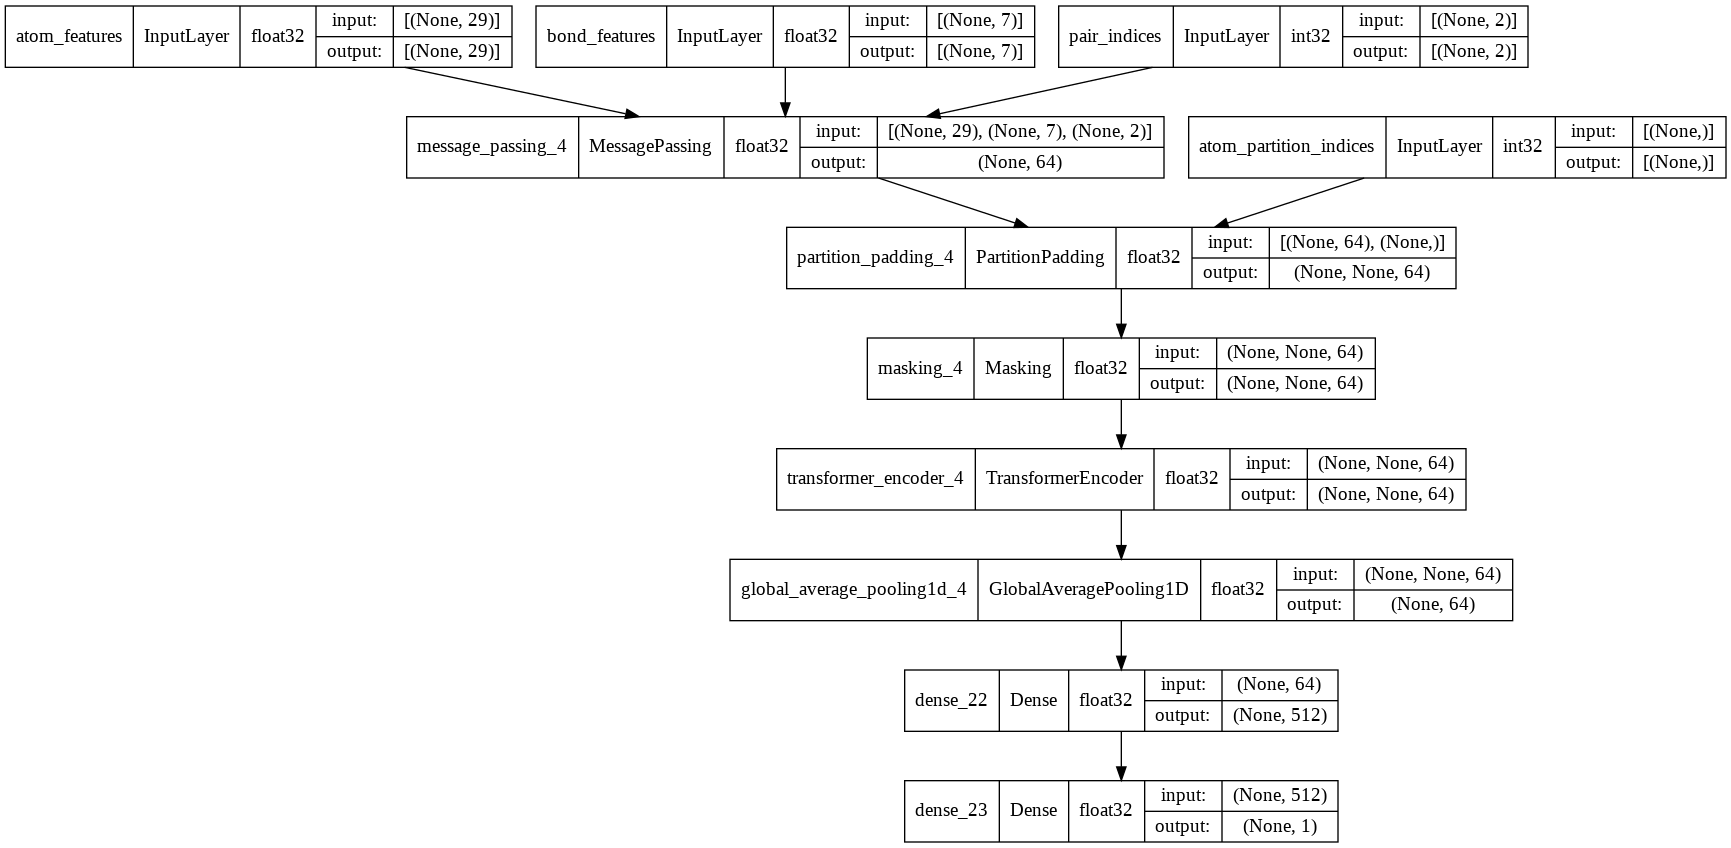

In [ ]:
#Initialize MPNN
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):
    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    atom_partition_indices = layers.Input(
        (), dtype="int32", name="atom_partition_indices"
    )

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = PartitionPadding(batch_size)([x, atom_partition_indices])

    x = layers.Masking()(x)

    x = TransformerEncoder(num_attention_heads, message_units, dense_units)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, atom_partition_indices],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.00025),
    metrics=['accuracy', keras.metrics.AUC(name="AUC")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [ ]:
#Train MPNN
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs= 50,
    verbose=2,
    class_weight={1: 2.0, 0: 0.5},
)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/partition_padding_4/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_4/partition_padding_4/Reshape:0", shape=(None, None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/partition_padding_4/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/message_passing_4/edge_network/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/message_passing_4/edge_network/Reshape_3:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("grad

37/37 - 5s - loss: 0.3627 - accuracy: 0.8892 - AUC: 0.6016 - val_loss: 0.2755 - val_accuracy: 0.9527 - val_AUC: 0.5370 - 5s/epoch - 125ms/step
Epoch 2/50
37/37 - 1s - loss: 0.3582 - accuracy: 0.8426 - AUC: 0.6058 - val_loss: 0.3205 - val_accuracy: 0.9527 - val_AUC: 0.4711 - 673ms/epoch - 18ms/step
Epoch 3/50
37/37 - 1s - loss: 0.3646 - accuracy: 0.8536 - AUC: 0.5876 - val_loss: 0.3230 - val_accuracy: 0.9527 - val_AUC: 0.4954 - 688ms/epoch - 19ms/step
Epoch 4/50
37/37 - 1s - loss: 0.3529 - accuracy: 0.8604 - AUC: 0.6196 - val_loss: 0.2837 - val_accuracy: 0.9527 - val_AUC: 0.5542 - 687ms/epoch - 19ms/step
Epoch 5/50
37/37 - 1s - loss: 0.3475 - accuracy: 0.9196 - AUC: 0.6218 - val_loss: 0.4627 - val_accuracy: 0.9527 - val_AUC: 0.4813 - 671ms/epoch - 18ms/step
Epoch 6/50
37/37 - 1s - loss: 0.3593 - accuracy: 0.9205 - AUC: 0.5660 - val_loss: 0.4731 - val_accuracy: 0.9527 - val_AUC: 0.5375 - 683ms/epoch - 18ms/step
Epoch 7/50
37/37 - 1s - loss: 0.3565 - accuracy: 0.9205 - AUC: 0.5634 - val_l

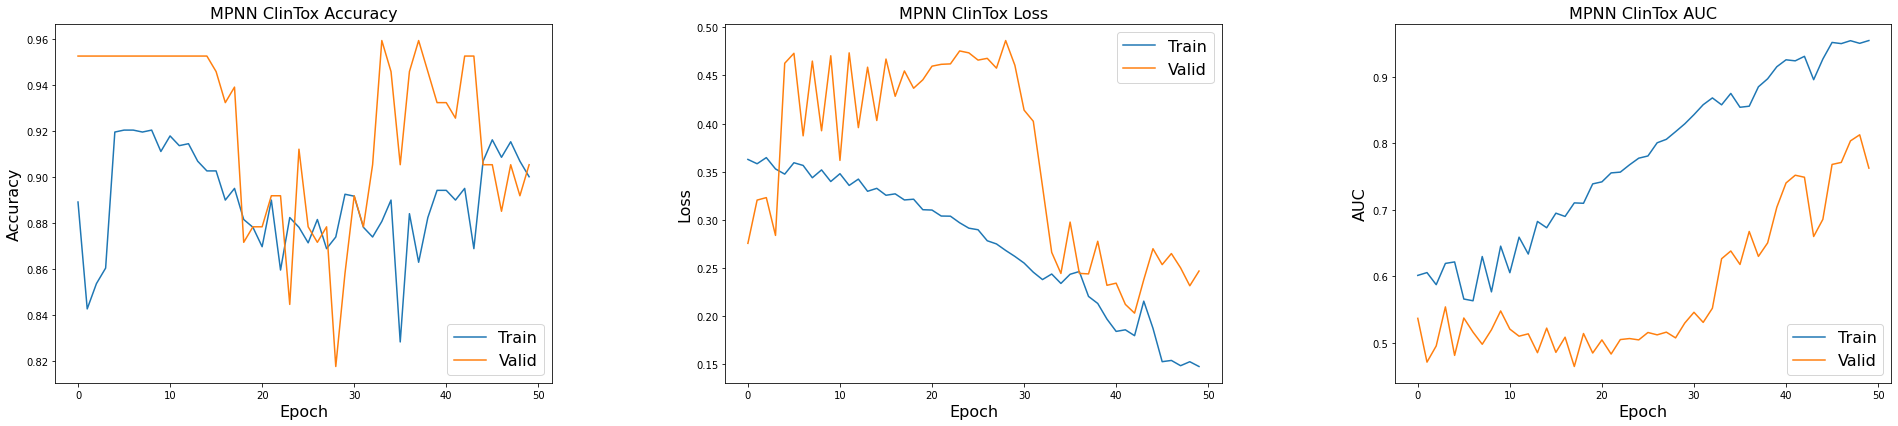

In [ ]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MPNN ClinTox Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='lower right', fontsize=16)

plt.subplot(132)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MPNN ClinTox Loss', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='upper right', fontsize=16)

plt.subplot(133)
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('MPNN ClinTox AUC', fontsize=16)
plt.ylabel('AUC', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='lower right', fontsize=16)
    
plt.subplots_adjust(top=0.92, bottom=0.09, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)

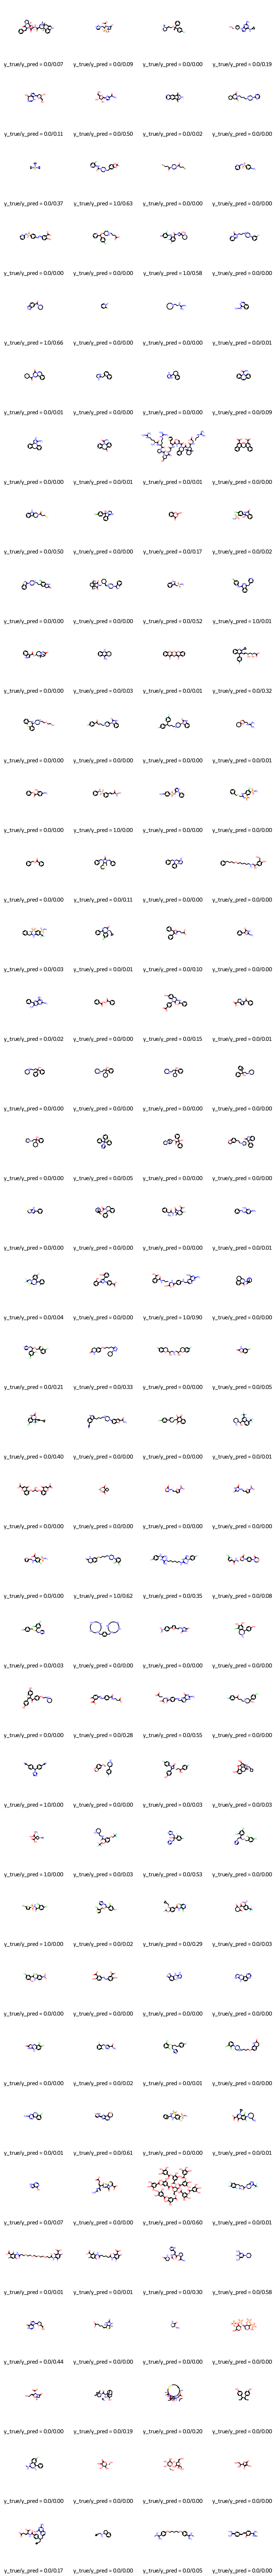

In [ ]:
#Predicting ClinTox task 2 test dataset using MPNN
molecules = [molecule_from_smiles(smi) for smi in testing_dataset.ids]
y_true = [x[1] for x in testing_dataset.y]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
mpnn_loss, mpnn_acc, mpnn_auc,*is_anything_else_being_returned = mpnn.evaluate(test_dataset)
print('\nTest loss:', mpnn_loss)
print('\nTest accuracy:', mpnn_acc)
print('\nTest AUROC:', mpnn_auc)

5/5 [==============================] - 0s 9ms/step - loss: 0.3368 - accuracy: 0.8851 - AUC: 0.6627

Test loss: 0.3368311822414398

Test accuracy: 0.8851351141929626

Test AUROC: 0.6626811027526855


In [ ]:
#Add to dataframe for mcnemar test
df['mpnn_preds'] = y_pred
threshold = 0.51
df['mpnn_thresholded'] = df['mpnn_preds']>threshold

## Custom Attention Model Trained on ClinTox

In [ ]:
train_dataset, valid_dataset, test_dataset = dataset

In [ ]:
#Data preprocessing
smiles_list = [x for x in itertools.chain(train_dataset.ids, valid_dataset.ids, test_dataset.ids)]

charset = set("".join(list(smiles_list))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in smiles_list]) + 5

In [ ]:
X_train, _ = vectorize(train_dataset.ids)
X_valid, _ = vectorize(valid_dataset.ids)
X_test, _ = vectorize(test_dataset.ids)

Y_train = train_dataset.y[:,1]
Y_valid = valid_dataset.y[:,1]
Y_test = test_dataset.y[:,1]

mol_str_train=[]
mol_str_valid=[]
mol_str_test=[]

for x in range(len(train_dataset.ids)):
    mol_str_train.append("".join([int_to_char[idx] for idx in np.argmax(X_train[x,:,:], axis=1)]))

for x in range(len(valid_dataset.ids)):
    mol_str_valid.append("".join([int_to_char[idx] for idx in np.argmax(X_test[x,:,:], axis=1)]))

for x in range(len(test_dataset.ids)):
    mol_str_test.append("".join([int_to_char[idx] for idx in np.argmax(X_test[x,:,:], axis=1)]))

vocab_size=len(charset)

In [ ]:
#Attention layer
class attention(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
#Initialize Custom model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 50, input_length=embed-1)) # embedding
model.add(tf.keras.layers.Conv1D(192,10,activation='relu'))   # convolution 1d
model.add(tf.keras.layers.BatchNormalization())                            
model.add(keras.layers.LSTM(224,return_sequences=True))
model.add(keras.layers.LSTM(384,return_sequences=True))
model.add(attention())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [ ]:
mol_str_train = np.asarray(mol_str_train)
mol_str_test = np.asarray(mol_str_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


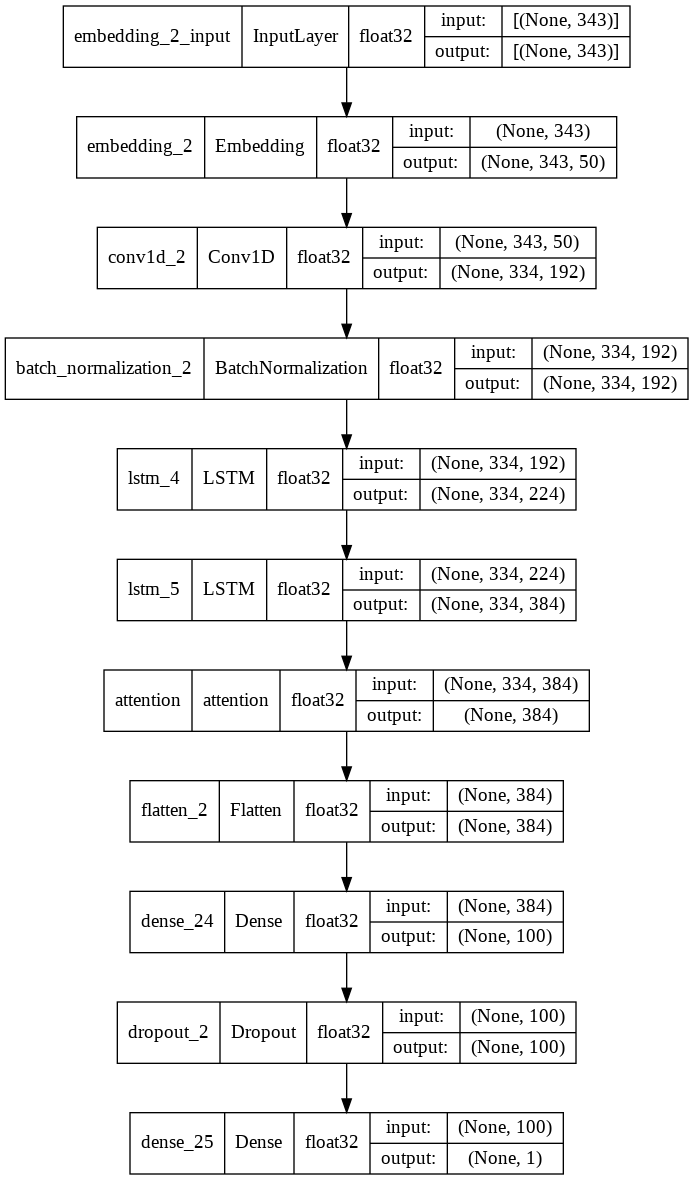

In [ ]:
optimizer = Adam(lr=0.00005)
lr_metric = get_lr_metric(optimizer)
loss = tfa.losses.SigmoidFocalCrossEntropy()
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.AUC(from_logits=True), lr_metric])
keras.utils.plot_model(model, show_dtype=True, show_shapes=True)

In [ ]:
#Train custom model
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00005, verbose=1, mode='auto',cooldown=0),
    #ModelCheckpoint(filepath="/content/drive/MyDrive/FINAL590_model_weights/CUSTOM", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

history =model.fit(x=np.argmax(X_train, axis=2), y=Y_train,
                              batch_size=60,
                              epochs=30,
                              validation_data=(np.argmax(X_valid, axis=2),Y_valid),
                              callbacks=callbacks_list)


Epoch 1/30
20/20 [==============================] - 6s 131ms/step - loss: 0.0497 - auc_2: 0.5166 - lr: 5.0000e-05 - val_loss: 0.0321 - val_auc_2: 0.3703 - val_lr: 5.0000e-05
Epoch 2/30
20/20 [==============================] - 2s 87ms/step - loss: 0.0265 - auc_2: 0.6567 - lr: 5.0000e-05 - val_loss: 0.0339 - val_auc_2: 0.5071 - val_lr: 5.0000e-05
Epoch 3/30
20/20 [==============================] - 2s 86ms/step - loss: 0.0229 - auc_2: 0.7944 - lr: 5.0000e-05 - val_loss: 0.0295 - val_auc_2: 0.4752 - val_lr: 5.0000e-05
Epoch 4/30
20/20 [==============================] - 2s 87ms/step - loss: 0.0170 - auc_2: 0.9290 - lr: 5.0000e-05 - val_loss: 0.0281 - val_auc_2: 0.7209 - val_lr: 5.0000e-05
Epoch 5/30
20/20 [==============================] - 2s 87ms/step - loss: 0.0145 - auc_2: 0.9397 - lr: 5.0000e-05 - val_loss: 0.0274 - val_auc_2: 0.8668 - val_lr: 5.0000e-05
Epoch 6/30
20/20 [==============================] - 2s 87ms/step - loss: 0.0155 - auc_2: 0.9429 - lr: 5.0000e-05 - val_loss: 0.0271 - 

In [ ]:
test_loss, test_auc, *is_anything_else_being_returned = model.evaluate(np.argmax(X_test, axis=2), Y_test)
print('\nTest loss:', test_loss)
print('\nTest AUC:', test_auc)

5/5 [==============================] - 0s 23ms/step - loss: 0.0028 - auc_2: 0.9982 - lr: 5.0000e-05

Test loss: 0.00275207101367414

Test AUC: 0.9981884360313416


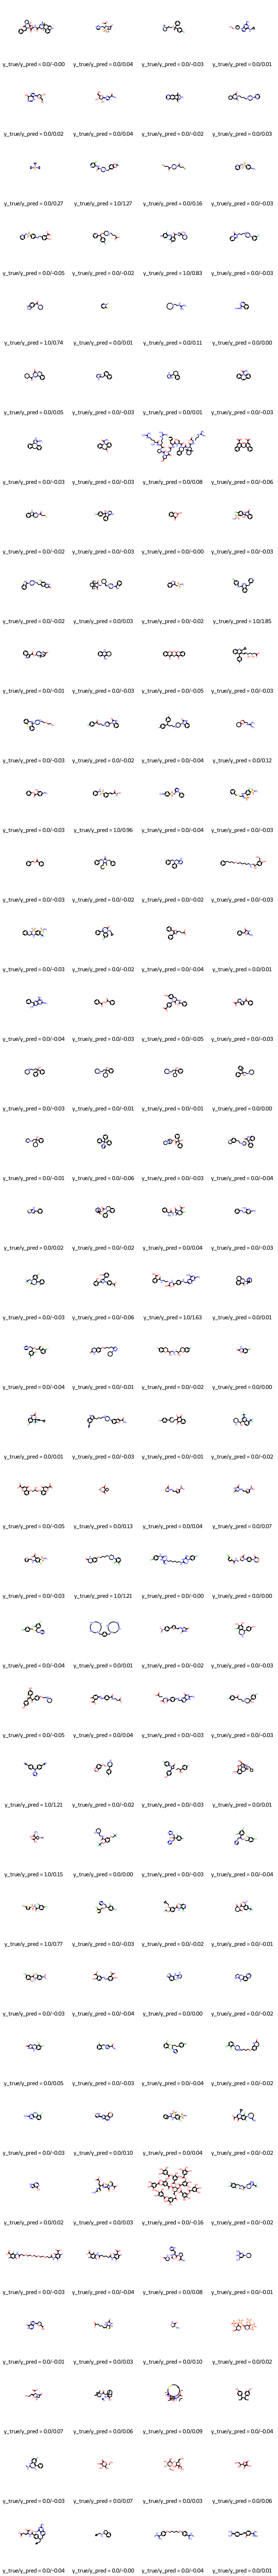

In [ ]:
#Predicting ClinTox task 2 test dataset using custom model
molecules = [molecule_from_smiles(smi) for smi in test_dataset.ids]
y_pred = (model.predict(x=np.argmax(X_test, axis=2)))
y_pred = y_pred.tolist()
legends = [f"y_true/y_pred = {Y_test[i]}/{y_pred[i][0]:.2f}" for i in range(len(Y_test))]
Chem.Draw.MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
df['attn_preds'] = [y[0] for y in y_pred]
threshold = .1
df['attn_thresholded'] = df['attn_preds']>threshold

In [ ]:
df = df.drop(columns=['mol'])

## Classification Results

### AUC

Text(0.5, 1.0, 'ClinTox AUC Performance')

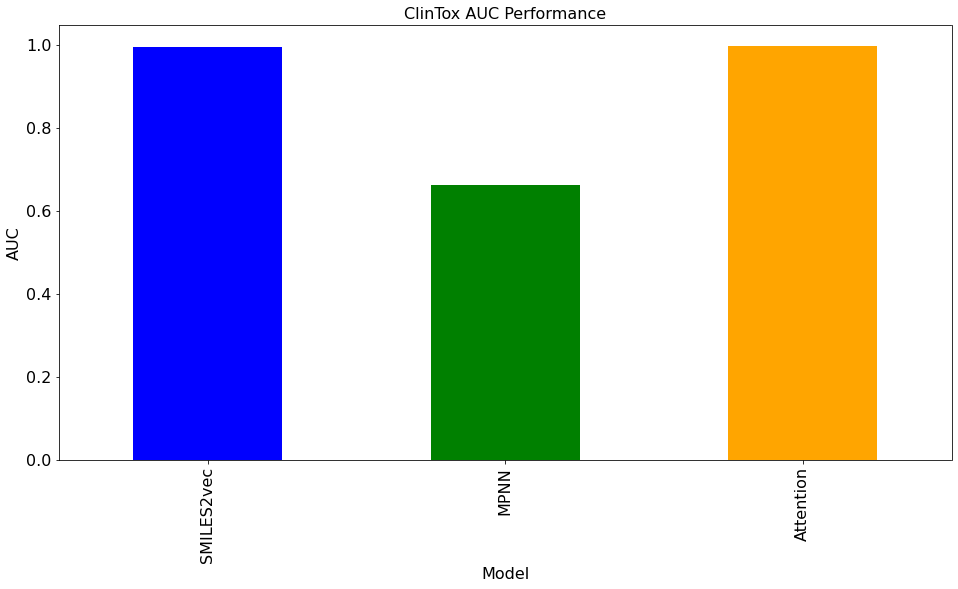

In [ ]:
#Summarize classification results on test dataset
plt.figure(figsize=(16, 8))
plt.subplot(111)
auc_data = {"AUC":[0.9934781789779663, 0.6626811027526855, 0.9982]}
index = ["SMILES2vec", "MPNN", "Attention"]
auc_df= pd.DataFrame(data=auc_data, index=index)
auc_df['AUC'].plot(kind="bar", color=['blue', 'green', 'orange'], fontsize=16)
plt.xlabel('Model',fontsize=16)
plt.ylabel('AUC',fontsize=16)
plt.title('ClinTox AUC Performance',fontsize=16)

### Precision Recall

In [ ]:
#Precision vs. Threshold
threshold_values = np.arange(-0.5, 1, 0.1)

In [ ]:
df['y_true'] =[Y_test[i] for i in range(len(Y_test))]

In [ ]:
from deepchem.metrics.metric import threshold_predictions

In [ ]:
precision_metric = dc.metrics.precision_score
smiles_precision_scores = [precision_metric(df['y_true'], df['base_preds']>t) for t in threshold_values]
mpnn_precision_scores = [precision_metric(df['y_true'], df['mpnn_preds']>t) for t in threshold_values]
attn_precision_scores = [precision_metric(df['y_true'], df['attn_preds']>t) for t in threshold_values]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
recall_metric = dc.metrics.recall_score
smiles_recall_scores = [recall_metric(df['y_true'], df['base_preds']>t) for t in threshold_values]
mpnn_recall_scores = [recall_metric(df['y_true'], df['mpnn_preds']>t) for t in threshold_values]
attn_recall_scores = [recall_metric(df['y_true'], df['attn_preds']>t) for t in threshold_values]

Text(0.5, 1.0, 'Precision Scores')

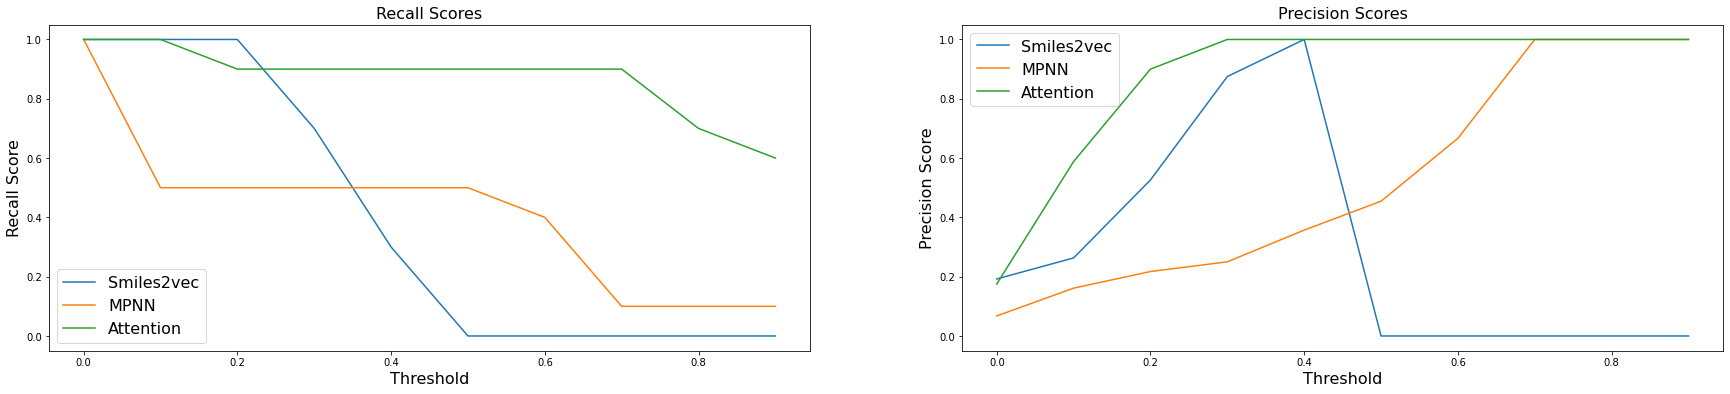

In [ ]:
#Graph Recall vs. Threshold and Precision vs. Threshold
plt.figure(figsize=(30, 6))
plt.subplot(121)
plt.plot(threshold_values, smiles_recall_scores)
plt.plot(threshold_values, mpnn_recall_scores)
plt.plot(threshold_values, attn_recall_scores)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Recall Score", fontsize=16)
plt.legend(['Smiles2vec', 'MPNN', 'Attention'], loc='lower left', fontsize=16)
plt.title("Recall Scores", fontsize=16)

plt.subplot(122)
plt.plot(threshold_values, smiles_precision_scores)
plt.plot(threshold_values, mpnn_precision_scores)
plt.plot(threshold_values, attn_precision_scores)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Precision Score", fontsize=16)
plt.legend(['Smiles2vec', 'MPNN', 'Attention'], loc='upper left', fontsize=16)
plt.title("Precision Scores", fontsize=16)

Text(0, 0.5, 'Attention Precision')

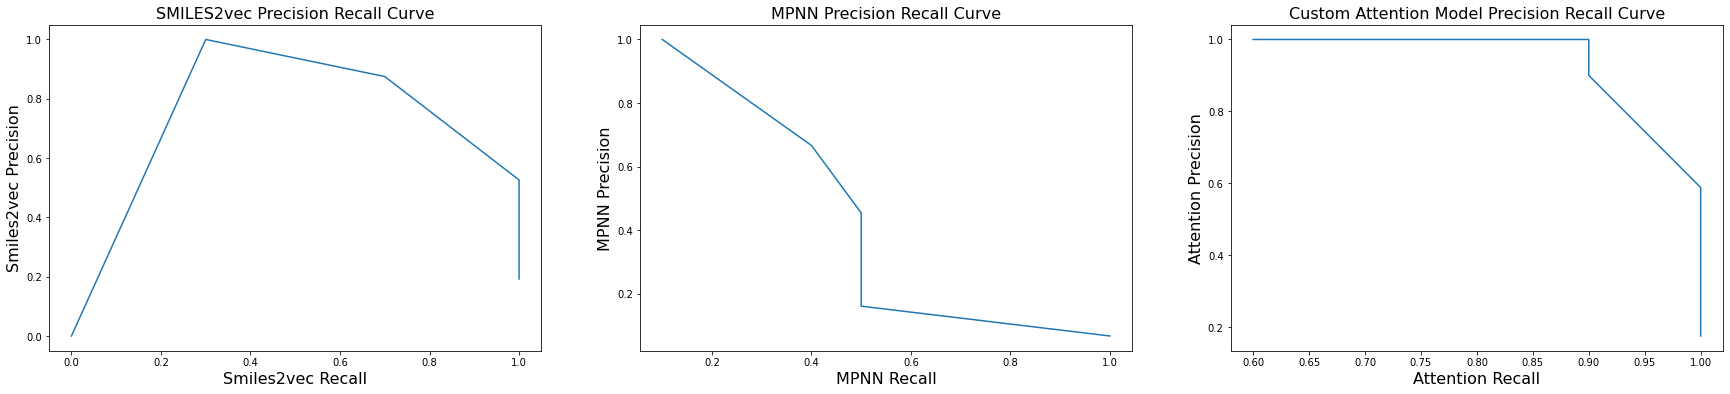

In [ ]:
plt.figure(figsize=(30, 6))
#Plot Recall vs. Precision for all the models
plt.subplot(131)
plt.plot(smiles_recall_scores, smiles_precision_scores)
plt.title('SMILES2vec Precision Recall Curve', fontsize=16)
plt.xlabel("Smiles2vec Recall", fontsize=16)
plt.ylabel("Smiles2vec Precision", fontsize=16)

#Plot Recall vs. Precision for all the models
plt.subplot(132)
plt.plot(mpnn_recall_scores, mpnn_precision_scores)
plt.title('MPNN Precision Recall Curve', fontsize=16)
plt.xlabel("MPNN Recall", fontsize=16)
plt.ylabel("MPNN Precision", fontsize=16)

#Plot Recall vs. Precision for all the models
plt.subplot(133)
plt.plot(attn_recall_scores, attn_precision_scores)
plt.title('Custom Attention Model Precision Recall Curve', fontsize=16)
plt.xlabel("Attention Recall", fontsize=16)
plt.ylabel("Attention Precision", fontsize=16)


In [ ]:
print(smiles_precision_scores)
print(mpnn_precision_scores)
print(attn_precision_scores)

[0.19230769230769232, 0.2631578947368421, 0.5263157894736842, 0.875, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.06756756756756757, 0.16129032258064516, 0.21739130434782608, 0.25, 0.35714285714285715, 0.45454545454545453, 0.6666666666666666, 1.0, 1.0, 1.0]
[0.17543859649122806, 0.5882352941176471, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Since we are focusing on trying to identify as many drugs as possibel that would be FDA approved, we want a model that identifies as many candidates as possible, which indicates we want a model with high precision. Therefore, we chose our thresholds for predictions to be 0.2, .51, and 0.1 for the SMILES2vec, mpnn, and custom model predictions respectively.

###McNemar Test

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
df['truth'] = df['y_true']>.5
df['base_correct']= df['threshold_preds']==df['truth']
df['mpnn_correct']= df['mpnn_thresholded']==df['truth']
df['attn_correct']= df['attn_thresholded']==df['truth']

SMILES2vec vs Custom

In [ ]:
smi_custom_conttable = pd.crosstab(df['attn_correct'],df['base_correct'])
smi_custom_conttable

base_correct,False,True
attn_correct,,
False,2,5
True,7,134


In [ ]:
## SMILES2vec vs Custom Attention Model Contingency Table
smi_custom_conttable = [[smi_custom_conttable.to_numpy()[1,1],smi_custom_conttable.to_numpy()[1,0]],
                       [smi_custom_conttable.to_numpy()[0,1],smi_custom_conttable.to_numpy()[0,0]]]
smi_custom_conttable

[[134, 7], [5, 2]]

In [ ]:
# calculate mcnemar test
result = mcnemar(smi_custom_conttable, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

statistic=5.000, p-value=0.774
Same proportions of errors (fail to reject H0)


MPNN vs Custom

In [ ]:
mpnn_custom_conttable = pd.crosstab(df['attn_correct'],df['mpnn_correct'])
mpnn_custom_conttable

mpnn_correct,False,True
attn_correct,,
False,1,6
True,10,131


In [ ]:
## MPNN vs Custom Attention Model Contingency Table
mpnn_custom_conttable = [[mpnn_custom_conttable.to_numpy()[1,1],mpnn_custom_conttable.to_numpy()[1,0]],
                       [mpnn_custom_conttable.to_numpy()[0,1],mpnn_custom_conttable.to_numpy()[0,0]]]
mpnn_custom_conttable

[[131, 10], [6, 1]]

In [ ]:
# calculate mcnemar test
result = mcnemar(mpnn_custom_conttable, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

statistic=6.000, p-value=0.454
Same proportions of errors (fail to reject H0)


### Discussion

Based on our results for AUC, our model has a high AUC compared to SMILES2vec and MPNN and outperformed both of these models with an AUC of 0.998. 

In reviewing the precision and recallfor each model, we see that our custom model has the highest precision across the board out of all the models for classification on ClinTox with recall being highest at all but one threshold for SMILES2vec.

In directly comparing the models, we used the McNemar test to compare the strength of our model to MPNN and SMILES2vec, and found that even though our models did seem to perform better in precision-recall, and AUC, the proportion of errors seems to be the same across all three models, which would suggest that at best, our custom model has on par performance with SMILES2vec and MPNN. Perhaps we would see a greater disparity after resampling the training dataset using SMOTE to increase the proportion of the minority class. This would have been our next step had we found more time to continue the project.

# Performance of SMILES2vec, MPNN, and Custom Attention on FreeSolv Regression

## SMILES2vec Trained on FreeSolv

In [ ]:
tasks, dataset, transformers = dc.molnet.load_freesolv()
train_dataset, valid_dataset, test_dataset = dataset

In [ ]:
smiles_list = [x for x in itertools.chain(train_dataset.ids, valid_dataset.ids, test_dataset.ids)]

charset = set("".join(list(smiles_list))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in smiles_list]) + 5

In [ ]:
X_train, _ = vectorize(train_dataset.ids)
X_valid, _ = vectorize(valid_dataset.ids)
X_test, _ = vectorize(test_dataset.ids)

Y_train = train_dataset.y
Y_valid = valid_dataset.y
Y_test = test_dataset.y

In [ ]:
mol_str_train=[]
mol_str_test=[]
mol_str_valid=[]
for x in range(len(train_dataset.ids)):
 
    mol_str_train.append("".join([int_to_char[idx] for idx in np.argmax(X_train[x,:,:], axis=1)]))
    
for x in range(len(test_dataset.ids)):
    mol_str_test.append("".join([int_to_char[idx] for idx in np.argmax(X_test[x,:,:], axis=1)]))

for x in range(len(valid_dataset.ids)):
    mol_str_valid.append("".join([int_to_char[idx] for idx in np.argmax(X_test[x,:,:], axis=1)]))

vocab_size=len(charset)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 50, input_length=embed-1))
model.add(tf.keras.layers.Conv1D(192,10,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())                            
model.add(keras.layers.LSTM(224,return_sequences=True))
model.add(keras.layers.LSTM(384,return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [ ]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [ ]:
mol_str_train = np.asarray(mol_str_train)
mol_str_test = np.asarray(mol_str_test)
mol_str_valid = np.asarray(mol_str_valid)

In [ ]:
optimizer = Adam(lr=0.003)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), coeff_determination, lr_metric])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-3, verbose=1, mode='auto',cooldown=0),
    #ModelCheckpoint(filepath="/content/drive/MyDrive/FINAL590_model_weights/SMILES2vec_reg", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')
    
]



history =model.fit(x=np.argmax(X_train, axis=2), y=Y_train,
                              batch_size=32,
                              epochs=50,
                              validation_data=(np.argmax(X_valid, axis=2),Y_valid),
                              callbacks=callbacks_list)

Epoch 1/50
17/17 [==============================] - 5s 66ms/step - loss: 24.2794 - root_mean_squared_error: 4.9274 - coeff_determination: -18112.3945 - lr: 0.0030 - val_loss: 0.6225 - val_root_mean_squared_error: 0.7890 - val_coeff_determination: -0.1334 - val_lr: 0.0030
Epoch 2/50
17/17 [==============================] - 0s 20ms/step - loss: 1.1006 - root_mean_squared_error: 1.0491 - coeff_determination: -740773.3125 - lr: 0.0030 - val_loss: 7.5341 - val_root_mean_squared_error: 2.7448 - val_coeff_determination: -13.1220 - val_lr: 0.0030
Epoch 3/50
17/17 [==============================] - 0s 20ms/step - loss: 1.1509 - root_mean_squared_error: 1.0728 - coeff_determination: -19971.6973 - lr: 0.0030 - val_loss: 0.5248 - val_root_mean_squared_error: 0.7244 - val_coeff_determination: 0.0353 - val_lr: 0.0030
Epoch 4/50
17/17 [==============================] - 0s 20ms/step - loss: 0.8842 - root_mean_squared_error: 0.9403 - coeff_determination: -195898.4844 - lr: 0.0030 - val_loss: 0.4951 - v

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'coeff_determination', 'lr', 'val_loss', 'val_root_mean_squared_error', 'val_coeff_determination', 'val_lr'])


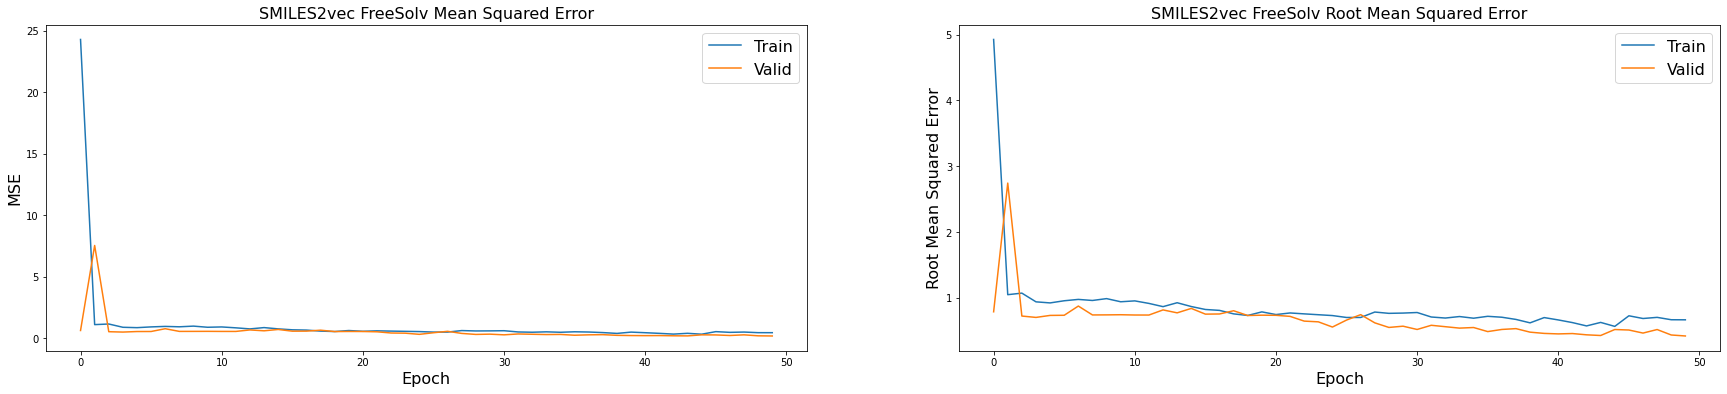

In [ ]:
#Visualize MSE and RMSE on SMILES2vec FreeSolv Data 
plt.figure(figsize=(30, 6))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SMILES2vec FreeSolv Mean Squared Error', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='upper right', fontsize=16)

plt.subplot(122)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('SMILES2vec FreeSolv Root Mean Squared Error', fontsize=16)
plt.ylabel('Root Mean Squared Error', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='upper right', fontsize=16)

The root mean squared error is 1.000 kcal/mol for the FreeSolv training dataset. Since loss remains pretty consistent after 18 epochs, the model has been trained enough. Also, since MSE and RMSE for training is slightly higher than MSE and RMSE for validation, the model could have over-learned the training set and might not be as generalizable to compounds outside the training data. 

In [ ]:
#Evaluate model on test set
smiles_mse, smiles_rmse, *is_anything_else_being_returned = model.evaluate(np.argmax(X_test, axis=2), Y_test)
print('\nTest mse:', smiles_mse)
print('\nTest rmse:', smiles_rmse)

3/3 [==============================] - 1s 9ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004 - coeff_determination: -446575.0312 - lr: 0.0010

Test mse: 0.2504085600376129

Test rmse: 0.5004083514213562


## MPNN Trained on FreeSolv

In [ ]:
training_dataset, validation_dataset, testing_dataset = dataset

In [ ]:
# Train set
x_train = graphs_from_smiles(training_dataset.ids)
y_train = training_dataset.y

# Valid set
x_valid = graphs_from_smiles(validation_dataset.ids)
y_valid = validation_dataset.y

# Test set
x_test = graphs_from_smiles(testing_dataset.ids)
y_test = testing_dataset.y

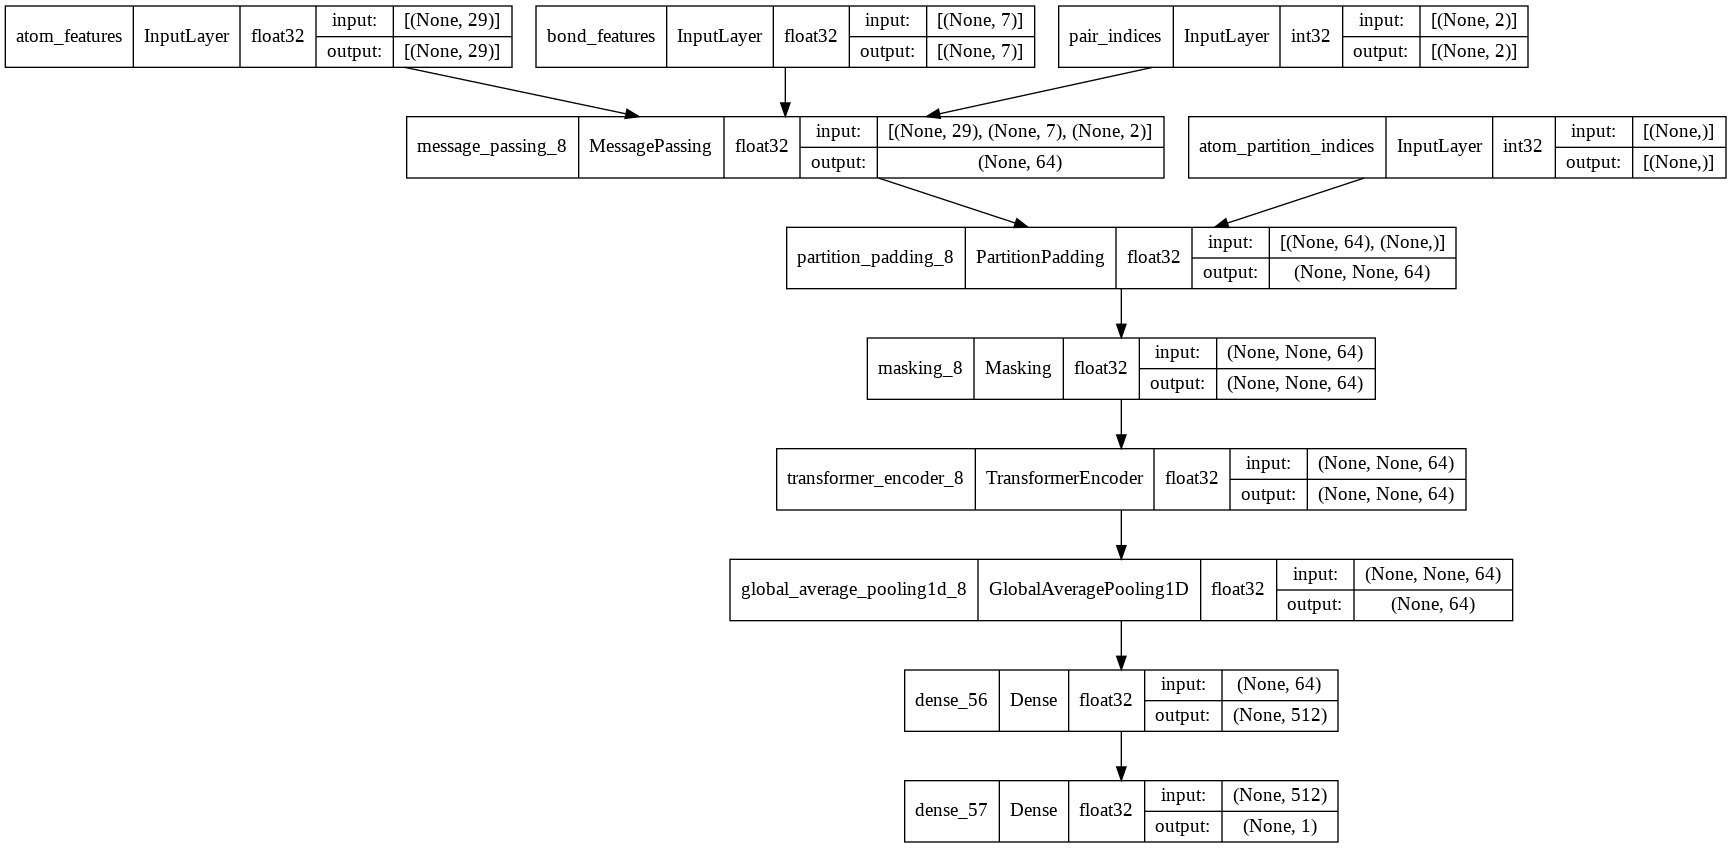

In [ ]:
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=0.00025),
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE"), coeff_determination],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    epochs= 40,
    validation_data=valid_dataset,
    verbose=2
)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_8/partition_padding_8/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_8/partition_padding_8/Reshape:0", shape=(None, None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_8/partition_padding_8/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_8/message_passing_8/edge_network/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_8/message_passing_8/edge_network/Reshape_3:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("grad

17/17 - 5s - loss: 1.0064 - RMSE: 1.0032 - coeff_determination: -4.2039e+05 - val_loss: 0.4835 - val_RMSE: 0.6953 - val_coeff_determination: 0.1154 - 5s/epoch - 276ms/step
Epoch 2/40
17/17 - 0s - loss: 0.8914 - RMSE: 0.9441 - coeff_determination: -3.5362e+05 - val_loss: 0.4300 - val_RMSE: 0.6558 - val_coeff_determination: 0.2117 - 293ms/epoch - 17ms/step
Epoch 3/40
17/17 - 0s - loss: 0.8143 - RMSE: 0.9024 - coeff_determination: -2.6592e+05 - val_loss: 0.3781 - val_RMSE: 0.6149 - val_coeff_determination: 0.3154 - 301ms/epoch - 18ms/step
Epoch 4/40
17/17 - 0s - loss: 0.7635 - RMSE: 0.8738 - coeff_determination: -2.4632e+05 - val_loss: 0.3620 - val_RMSE: 0.6016 - val_coeff_determination: 0.3497 - 312ms/epoch - 18ms/step
Epoch 5/40
17/17 - 0s - loss: 0.7463 - RMSE: 0.8639 - coeff_determination: -2.4169e+05 - val_loss: 0.3551 - val_RMSE: 0.5959 - val_coeff_determination: 0.3612 - 327ms/epoch - 19ms/step
Epoch 6/40
17/17 - 0s - loss: 0.7362 - RMSE: 0.8580 - coeff_determination: -2.4182e+05 -

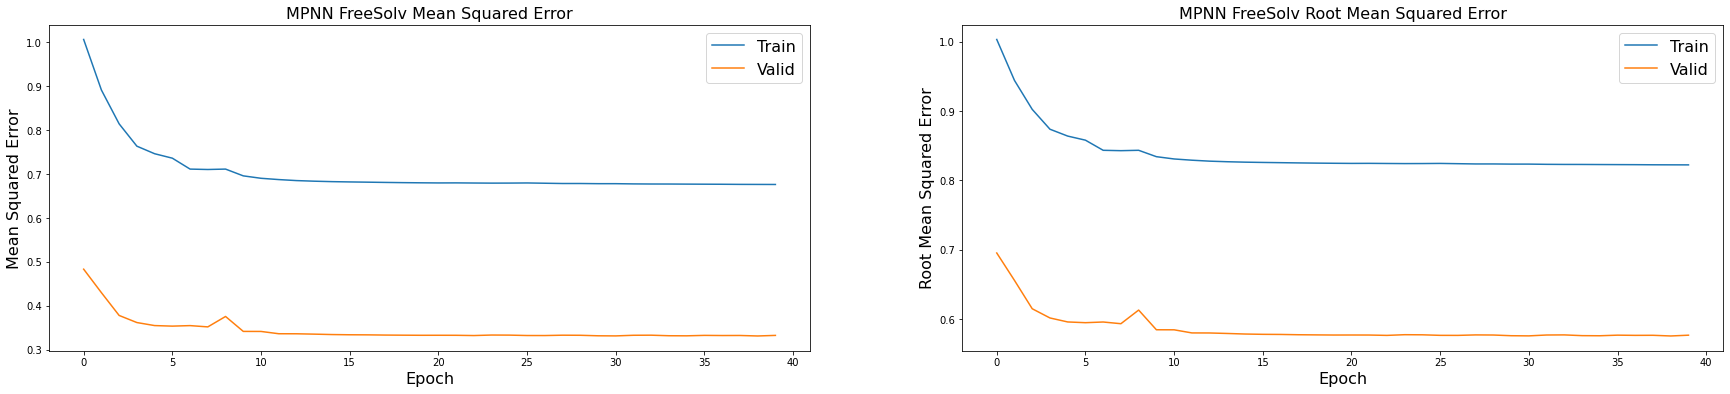

In [ ]:
#Visualize MSE and RMSE for MPNN on FreeSolv training and validation datasets

plt.figure(figsize=(30, 6))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MPNN FreeSolv Mean Squared Error', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='upper right', fontsize=16)

plt.subplot(122)
plt.plot(history.history['RMSE'])
plt.plot(history.history['val_RMSE'])
plt.title('MPNN FreeSolv Root Mean Squared Error', fontsize=16)
plt.ylabel('Root Mean Squared Error', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Valid'], loc='upper right', fontsize=16)

The MSE and RMSE for validation data set is lower than for the training data set using the MPNN trained on FreeSolv. This could be due to imbalance in the FreeSolv dataset. Given more time, we would use k-fold cross validation to reevalute the data split. 

In [ ]:
#Evalute MPNN on Test dataset
mpnntest_mse, mpnntest_rmse, *is_anything_else_being_returned = mpnn.evaluate(test_dataset)
print('\nTest mse:', mpnntest_mse)
print('\nTest rmse:', mpnntest_rmse)

3/3 [==============================] - 0s 8ms/step - loss: 0.6404 - RMSE: 0.8003 - coeff_determination: -5338513.0000

Test mse: 0.6404205560684204

Test rmse: 0.8002628087997437


##Custom Attention Model Trained on FreeSolv

In [ ]:
tasks, dataset, transformers = dc.molnet.load_freesolv()
train_dataset, valid_dataset, test_dataset = dataset

smiles_list = [x for x in itertools.chain(train_dataset.ids, valid_dataset.ids, test_dataset.ids)]

charset = set("".join(list(smiles_list))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in smiles_list]) + 5

X_train, _ = vectorize(train_dataset.ids)
X_valid, _ = vectorize(valid_dataset.ids)
X_test, _ = vectorize(test_dataset.ids)

Y_train = train_dataset.y
Y_valid = valid_dataset.y
Y_test = test_dataset.y

vocab_size=len(charset)

In [ ]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, 50, input_length=embed-1)) # embedding
model2.add(tf.keras.layers.Conv1D(192,10,activation='relu'))   # convolution 1d
model2.add(tf.keras.layers.BatchNormalization())                            
model2.add(keras.layers.LSTM(224,return_sequences=True))
model2.add(keras.layers.LSTM(384,return_sequences=True))
model2.add(attention())
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(100, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(1, activation='linear'))

In [ ]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model2.compile(loss="mse", optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(),coeff_determination, lr_metric])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4, verbose=1, mode='auto',cooldown=0),
    #ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')
]

history2 =model2.fit(x=np.argmax(X_train, axis=2), y=Y_train,
                              batch_size=32,
                              epochs=50,
                              validation_data=(np.argmax(X_valid, axis=2),Y_valid),
                              callbacks=callbacks_list)

Epoch 1/50
17/17 [==============================] - 4s 67ms/step - loss: 0.8444 - root_mean_squared_error: 0.9189 - coeff_determination: -350375.7500 - lr: 2.5000e-04 - val_loss: 0.5652 - val_root_mean_squared_error: 0.7518 - val_coeff_determination: -0.0305 - val_lr: 2.5000e-04
Epoch 2/50
17/17 [==============================] - 0s 20ms/step - loss: 0.6240 - root_mean_squared_error: 0.7899 - coeff_determination: -15379.5332 - lr: 2.5000e-04 - val_loss: 0.5273 - val_root_mean_squared_error: 0.7262 - val_coeff_determination: 0.0372 - val_lr: 2.5000e-04
Epoch 3/50
17/17 [==============================] - 0s 20ms/step - loss: 0.4839 - root_mean_squared_error: 0.6957 - coeff_determination: -66758.3125 - lr: 2.5000e-04 - val_loss: 0.5355 - val_root_mean_squared_error: 0.7318 - val_coeff_determination: 0.0226 - val_lr: 2.5000e-04
Epoch 4/50
17/17 [==============================] - 0s 20ms/step - loss: 0.3693 - root_mean_squared_error: 0.6077 - coeff_determination: -106171.3750 - lr: 2.5000e-

In [ ]:
#Evaluate model on test set
attn_smiles_mse, attn_smiles_rmse, *is_anything_else_being_returned = model2.evaluate(np.argmax(X_test, axis=2), Y_test)
print('\nTest MSE:', attn_smiles_mse)
print('\nTest RMSE:', attn_smiles_rmse)

3/3 [==============================] - 1s 8ms/step - loss: 0.1110 - root_mean_squared_error: 0.3332 - coeff_determination: -146302.8594 - lr: 1.0000e-04

Test MSE: 0.1110399141907692

Test RMSE: 0.3332265317440033


## Regression Results

### MSE and RMSE

Text(0.5, 1.0, 'FreeSolv RMSE Performance')

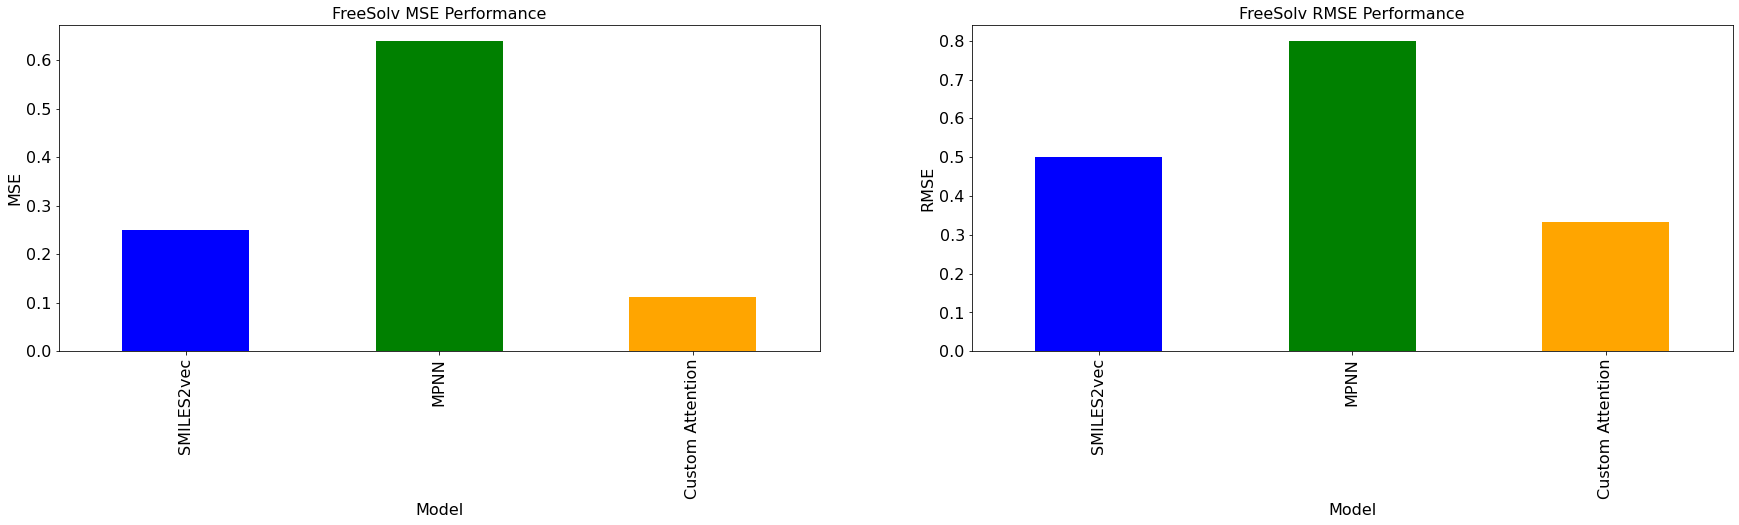

In [ ]:
#Vertical bar chart
plt.figure(figsize=(30, 6))
plt.subplot(121)
regression_data = {"MSE":[smiles_mse, mpnntest_mse, attn_smiles_mse]}
index = ["SMILES2vec", "MPNN", "Custom Attention"]
regression_df= pd.DataFrame(data=regression_data, index=index)
regression_df['MSE'].plot(kind="bar", color=['blue', 'green', 'orange'], fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.title('FreeSolv MSE Performance', fontsize=16)

plt.subplot(122)
rmse_data = {"RMSE":[smiles_rmse, mpnntest_rmse, attn_smiles_rmse]}
index = ["SMILES2vec", "MPNN", "Custom Attention"]
rmse_df= pd.DataFrame(data=rmse_data, index=index)
rmse_df['RMSE'].plot(kind="bar", color=['blue', 'green', 'orange'], fontsize=16)
plt.xlabel('Model',fontsize=16)
plt.ylabel('RMSE',fontsize=16)
plt.title('FreeSolv RMSE Performance',fontsize=16)


From the bar graph above, you can see that MPNN has the highest MSE and RMSE than SMILES2vec and our custom model on FreeSolv dataset. Our custom model has the lowest MSE and RMSE values, however, when taking into consideration the coefficient of determinations for all the models, the SMILES2vec and custom attention values do not make sense, as in the values are out of the range between 0 to 1. The coefficient of determations for SMILES2vec and custom model are all negative, which means that the model is not learning any of the training dataset and that our model cannot perform regression for now.

# Adversarial Control on Custom Attention Model on ClinTox Classification

## Y-shuffling

In [ ]:
from numpy.random import permutation

In [ ]:
#Shuffle training data 
tasks, dataset, transformers = dc.molnet.load_clintox()
custom_train, custom_valid, custom_test = dataset
smiles_list = [x for x in itertools.chain(custom_train.ids, custom_valid.ids, custom_test.ids)]
charset = set("".join(list(smiles_list))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in smiles_list]) + 5
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
vocab_size=len(charset)

In [ ]:
X_shuffle_train, _ = vectorize(custom_train.ids)
X_shuffle_valid, _ = vectorize(custom_valid.ids)
X_shuffle_test, _ = vectorize(custom_test.ids)

Y_shuffle_train = permutation(custom_train.y[:,1])
Y_shuffle_valid = custom_valid.y[:,1]
Y_shuffle_test = custom_test.y[:,1]

In [ ]:
#Initialize Custom model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 50, input_length=embed-1)) # embedding
model.add(tf.keras.layers.Conv1D(192,10,activation='relu'))   # convolution 1d
model.add(tf.keras.layers.BatchNormalization())                            
model.add(keras.layers.LSTM(224,return_sequences=True))
model.add(keras.layers.LSTM(384,return_sequences=True))
model.add(attention())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [ ]:
optimizer = Adam(lr=0.00005)
lr_metric = get_lr_metric(optimizer)
loss = tfa.losses.SigmoidFocalCrossEntropy()
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.AUC(from_logits=True), lr_metric])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Train custom model
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00005, verbose=1, mode='auto',cooldown=0)
]

history =model.fit(x=np.argmax(X_shuffle_train, axis=2), y=Y_shuffle_train,
                              batch_size=60,
                              epochs=30,
                              validation_data=(np.argmax(X_shuffle_valid, axis=2),Y_shuffle_valid),
                              callbacks=callbacks_list)


Epoch 1/30
20/20 [==============================] - 6s 131ms/step - loss: 0.0776 - auc_6: 0.5175 - lr: 5.0000e-05 - val_loss: 0.0433 - val_auc_6: 0.5000 - val_lr: 5.0000e-05
Epoch 2/30
20/20 [==============================] - 2s 87ms/step - loss: 0.0356 - auc_6: 0.4832 - lr: 5.0000e-05 - val_loss: 0.0347 - val_auc_6: 0.3506 - val_lr: 5.0000e-05
Epoch 3/30
20/20 [==============================] - 2s 86ms/step - loss: 0.0294 - auc_6: 0.4972 - lr: 5.0000e-05 - val_loss: 0.0351 - val_auc_6: 0.3328 - val_lr: 5.0000e-05
Epoch 4/30
20/20 [==============================] - 2s 87ms/step - loss: 0.0300 - auc_6: 0.4667 - lr: 5.0000e-05 - val_loss: 0.0370 - val_auc_6: 0.4787 - val_lr: 5.0000e-05
Epoch 5/30
20/20 [==============================] - 2s 87ms/step - loss: 0.0283 - auc_6: 0.5374 - lr: 5.0000e-05 - val_loss: 0.0373 - val_auc_6: 0.4787 - val_lr: 5.0000e-05
Epoch 6/30
20/20 [==============================] - 2s 86ms/step - loss: 0.0295 - auc_6: 0.4632 - lr: 5.0000e-05 - val_loss: 0.0382 - 

In [ ]:
shuffle_test_loss, shuffle_test_auc, *is_anything_else_being_returned = model.evaluate(np.argmax(X_shuffle_test, axis=2), Y_shuffle_test)
print('\nTest loss:', shuffle_test_loss)
print('\nTest AUC:', shuffle_test_auc)

5/5 [==============================] - 0s 25ms/step - loss: 0.0351 - auc_6: 0.3101 - lr: 5.0000e-05

Test loss: 0.035122305154800415

Test AUC: 0.31014493107795715


We utilized y-shuffling in our training dataset on our custom model to perform adversarial control, and after evaluating the model on our test dataset, we get an AUC of 0.31, or below 0.5 which means the shuffled model is guessing and performs worse with y-shuffling. This means that our custom model is learning actual SMILES strings from the classification ClinTox dataset to make correct predictions of toxicity based on SMILES strings.

We did not perform y-shuffling on the Freesolv regression data set because as you can see from the coefficient of determination above, the model needs to be improved to learn inputs from Freesolv dataset. 

# Conclusion

Overall, our custom model performed past our expectations when it came to classification. However, we were not able to properly implement our custom model nor SMILES2vec for the regression task as we had initially set out to do. In the future, we would try to better understand why our models failed to fit to the dataset, but for now, we were surprised that our model managed to outperform MPNN and SMILES2vec in a classification task. Though the McNemar test suggests that our model is on par with those models, it is still surprising to us that simply adding attention to SMILES2vec to form our custom model would lead to high performance. For next steps, we hope to incorporate attention into MPNN to see how that compares with our custom attention model, SMILES2vec, as well as MPNN. 